In [164]:
from river.datasets import synth
from river import datasets, metrics, tree, drift, stream, preprocessing, naive_bayes

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import deque
from typing import Any, List, Optional
from enum import Enum
from pydantic import BaseModel

In [2]:
ds1 = np.random.normal(0, 1, 1000)
ds2 = np.random.normal(1, 3, 1000)
ds3 = np.random.normal(1, 1, 1000)
ds4 = np.random.normal(0, 2, 1000)
ds5 = np.random.normal(0.5, 4, 1000)
data_stream = np.concatenate((ds1, ds2, ds3, ds4, ds5), axis=0)

In [ ]:
jswin = drift.JSWIN(alpha=0.5, seed=42)
tres = []
drift_idx = []

for i, val in enumerate(data_stream):
    jswin.update(val)
    tres.append(jswin._js_value)
    if jswin.drift_detected:
        print(f"Change detected at index {i}, input value: {val}")
        drift_idx.append(i)

/home/telejkoi/github/river/river/drift/jswin.py:157: RuntimeWarning: divide by zero encountered in log
  p_hist * np.log(p_hist / (q_hist + EPS)) - p_hist + q_hist,
/home/telejkoi/github/river/river/drift/jswin.py:157: RuntimeWarning: invalid value encountered in multiply
  p_hist * np.log(p_hist / (q_hist + EPS)) - p_hist + q_hist,


Change detected at index 1192, input value: -0.8664643170552
Change detected at index 1561, input value: -1.8153332809013127
Change detected at index 1987, input value: 2.8615477401517597
Change detected at index 2220, input value: 0.5147237196069808
Change detected at index 2570, input value: 0.21319005741613706
Change detected at index 3003, input value: -2.041914760975238
Change detected at index 3357, input value: 2.1895990931943907
Change detected at index 4725, input value: 2.0277553614300774
Change detected at index 4904, input value: 1.2861009482359442


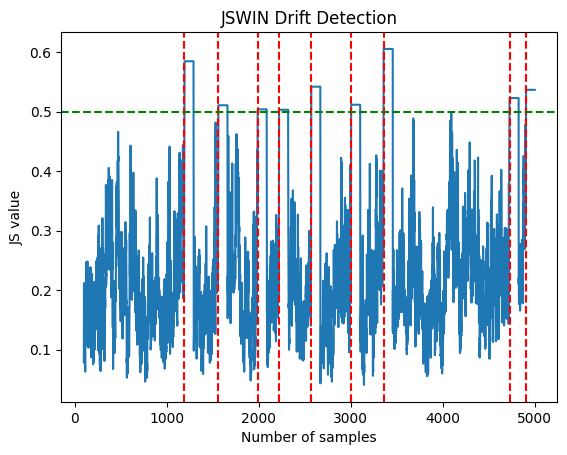

In [ ]:
plt.plot(tres)
plt.title('JSWIN Drift Detection')
plt.xlabel('Number of samples')
plt.ylabel('JS value')
for i in drift_idx:
    plt.axvline(x=i, color='r', linestyle='--', label='Drift Detected')
plt.axhline(y=jswin.alpha, color='g', linestyle='--', label='Threshold')
# plt.legend()
plt.show()

In [35]:
kswin = drift.KSWIN(alpha=0.001, seed=42)

for i, val in enumerate(data_stream):
    kswin.update(val)
    if kswin.drift_detected:
        print(f"Change detected at index {i}, input value: {val}")

Change detected at index 477, input value: -0.9231614155473554
Change detected at index 1388, input value: -3.7677599105236244
Change detected at index 2294, input value: 0.6265873093921769


In [ ]:
random.Random(42)
res = {}
colors = {"JSWIN": "slategrey", "ADWIN": "red", "KSWIN": "green", "PH": "orange", "HDDM_A": "blue", "HDDM_W": "purple"}

jswin = drift.JSWIN(alpha=0.55, seed=42)
adwin = drift.ADWIN(delta=0.001)
kswin = drift.KSWIN(alpha=0.001, seed=42)
hddm_a = drift.binary.HDDM_A(drift_confidence=10e-20)
hddm_w = drift.binary.HDDM_W(drift_confidence=10e-20)
ph = drift.PageHinkley(min_instances=100, delta=0.5)

dd_methods = {"JSWIN": jswin, "ADWIN": adwin, "KSWIN": kswin, "PH": ph, "HDDM_A": hddm_a, "HDDM_W": hddm_w}

for dd_method_name, dd_method in dd_methods.items():
    ind = []
    vals = []
    data_stream = np.concatenate((ds1, ds2, ds3, ds4, ds5), axis=0)
    for i, val in enumerate(data_stream):
        dd_method.update(float(val))
        vals.append(float(val))
        if dd_method.drift_detected:
            # print(f"Change detected at index {i}, input value: {val}")
            ind.append(i)

    res[dd_method_name] = {}
    res[dd_method_name]["ind"] = ind
    res[dd_method_name]["vals"] = vals

/home/telejkoi/github/river/river/drift/jswin.py:153: RuntimeWarning: divide by zero encountered in log
  p_hist * np.log(p_hist / (q_hist + EPS)) - p_hist + q_hist,
/home/telejkoi/github/river/river/drift/jswin.py:153: RuntimeWarning: invalid value encountered in multiply
  p_hist * np.log(p_hist / (q_hist + EPS)) - p_hist + q_hist,


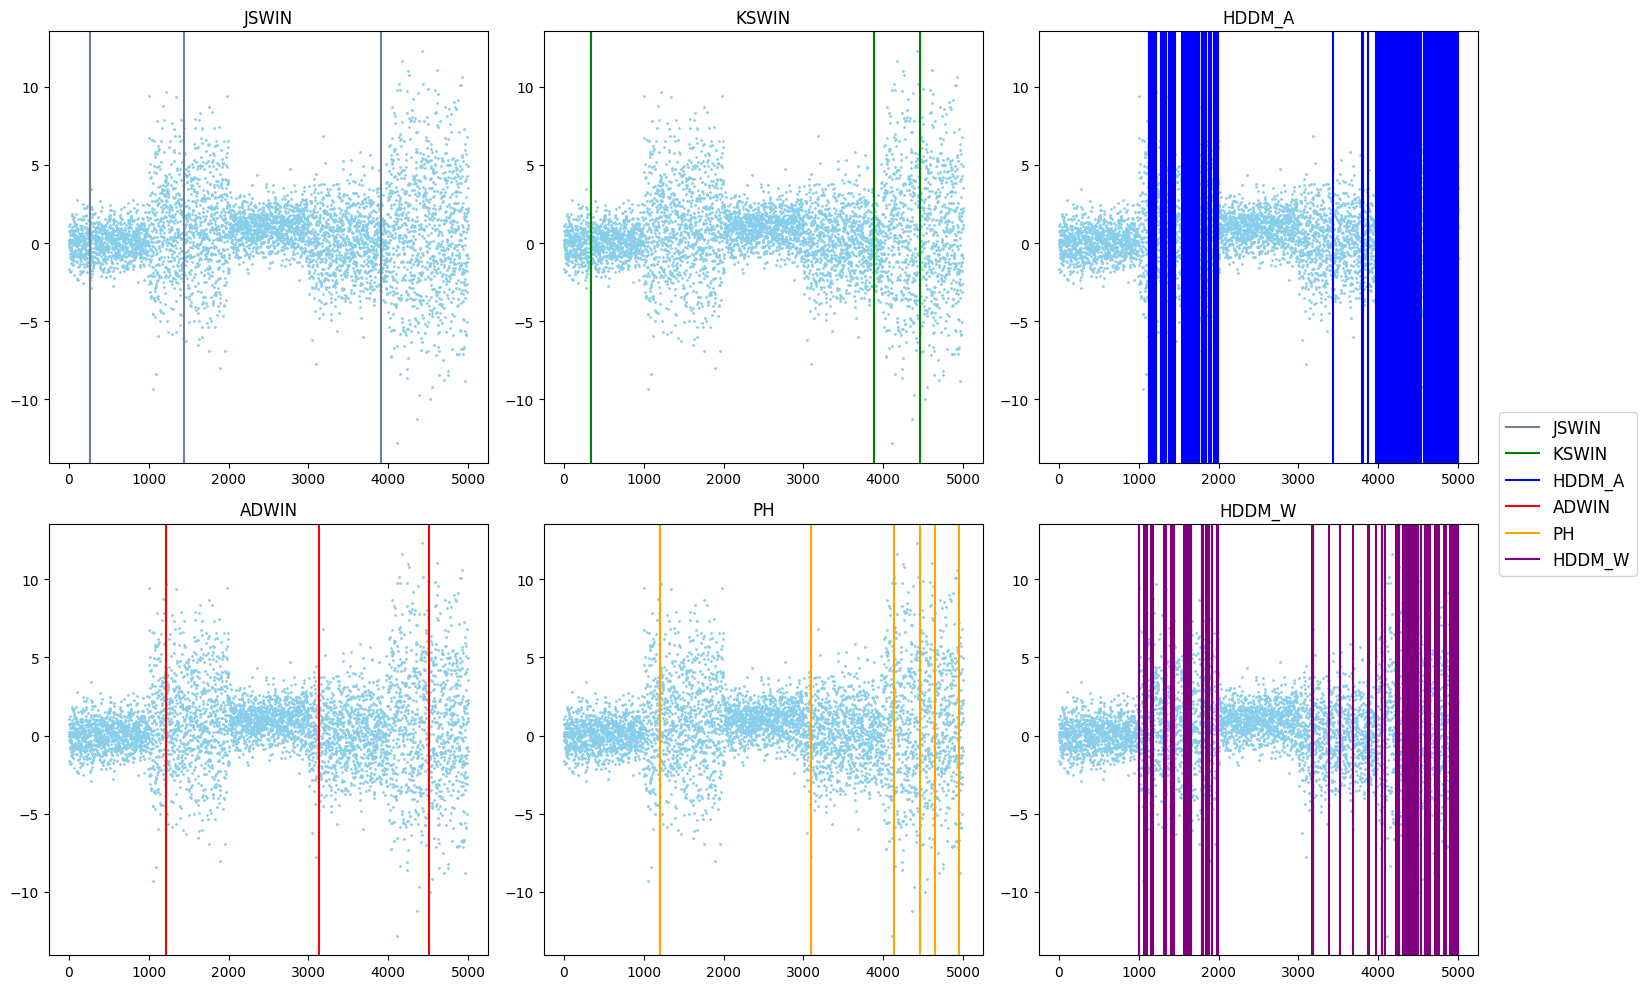

In [82]:
fig, ax = plt.subplots(2, 3)
fig.set_figheight(10)
fig.set_figwidth(15)

for i, (dd_method_name, _) in enumerate(dd_methods.items()):
    ax[i % 2, i // 2].scatter([i for i in range(len(vals))], vals, s=1, color="skyblue")
    first = True
    for drift_x in res[dd_method_name]["ind"]:
        if first:
            ax[i % 2, i // 2].axvline(x=drift_x, color=colors[dd_method_name], label=dd_method_name)
            first = False
        ax[i % 2, i // 2].axvline(x=drift_x, color=colors[dd_method_name])
    ax[i % 2, i // 2].set_title(dd_method_name, fontsize=12)

fig.tight_layout()
fig.legend(loc = "center right", fontsize=12, bbox_to_anchor=(1.10, 0.5))
plt.show()

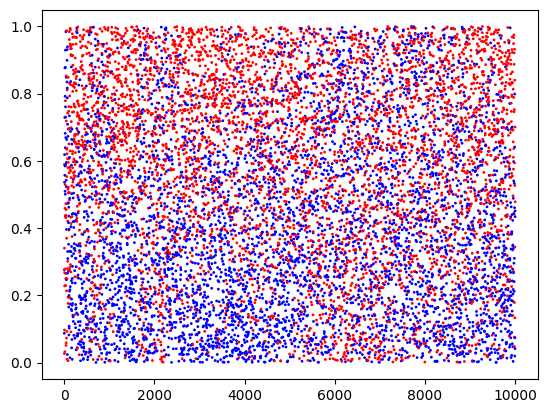

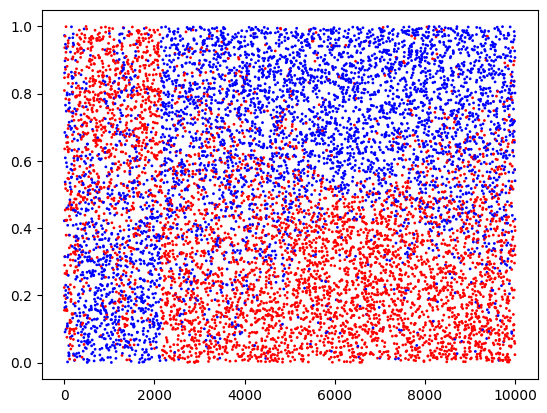

In [165]:
# decision boundary drift (real drift)
gen = synth.Hyperplane(seed=42, n_drift_features=2, n_features=2, mag_change=0.3)
dataset = iter(gen.take(10000))

X, y = [], []
for x, y_ in dataset:
    X.append(x)
    y.append(y_)
X = pd.DataFrame(X)
y = pd.Series(y)

colormap = np.array(['red', 'blue'])
plt.scatter([i for i in range(len(X[0]))], X[0], s=1, color=colormap[y])
plt.show()
plt.scatter([i for i in range(len(X[1]))], X[1], s=1, color=colormap[y])
plt.show()

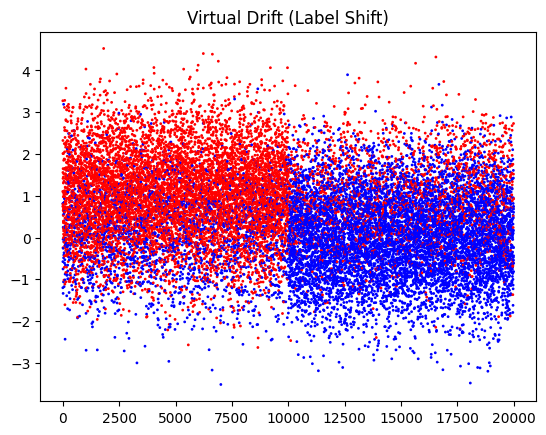

In [166]:
# label shift (virtual drift)
n = 10000
ratio = 0.2

X_pos = np.random.normal(0, 1, n)
X_neg = np.random.normal(1, 1, n)
n1 = int(n * ratio)
n2 = n - n1

X_first = np.concatenate((X_pos[:n1], X_neg[:n2]), axis=0)
y_first = np.concatenate((np.ones(n1), np.zeros(n2)), axis=0)
X_second = np.concatenate((X_pos[n1:], X_neg[n2:]), axis=0)
y_second = np.concatenate((np.ones(n2), np.zeros(n1)), axis=0)

p = np.random.permutation(len(X_first))
X_first, y_first = X_first[p], y_first[p]
p = np.random.permutation(len(X_second))
X_second, y_second = X_second[p], y_second[p]
X = np.concatenate((X_first, X_second), axis=0)
y = np.concatenate((y_first, y_second), axis=0)
X = pd.DataFrame(X)
y = pd.Series(y).astype('int')

colormap = np.array(['red', 'blue'])
plt.scatter([i for i in range(len(X[0]))], X[0], s=1, color=colormap[y])
plt.title('Virtual Drift (Label Shift)')
plt.show()

In [167]:
class DriftType(Enum):
    ERROR = 1
    CONCEPT = 2 # real drift or virtual drift
    NO_DRIFT = 3

class DriftDetectorsConfig(BaseModel):

    jswin_alpha: float = 0.5
    # itd....

In [ ]:
class ModelWithDriftDetector():

    def __init__(self, window_size: int, model_instance: Any, drift_type: DriftType, detector: Optional[Any]):
        """Initialize the model with drift detector."""
        self.window_size = window_size
        self.model_instance = model_instance
        self.drift_type = drift_type
        self.detector = detector
        self.drifts = []
        self.accs = []
        self.metric = metrics.ClassificationReport()
        self.model = preprocessing.StandardScaler() | self.model_instance()
        self.sliding_window = deque(maxlen=window_size)

    def run_iteration(self, i: int, x: Any, y:Any) -> None:
        """Run one iteration of the model with drift detection."""
        y_pred = self.model.predict_one(x)
        self._test(x, y, y_pred)
        self.model.learn_one(x, y)
        self._update_drift(x, y, y_pred)
        self._check_drift(i, verbose=0)
    
    def _test(self, x: Any, y: int, y_pred: Optional[int]) -> None:
        """Test the model on the input data."""
        if y_pred is not None:
            self.metric.update(y, y_pred)
        self.accs.append(self.metric._accuracy.get())
        self.sliding_window.append((x, y))
    
    def _update_drift(self, x: Any, y: int, y_pred: Optional[int] = None) -> None:
        """Update the drift detector with the new data."""
        if self.detector is None:
            return
        if self.drift_type == DriftType.ERROR:
            self.detector.update(int(y_pred != y if y_pred is not None else 0))
        elif self.drift_type == DriftType.CONCEPT:
            self.detector.update(x[0])
    
    def _check_drift(self, i: int, verbose: int = 0) -> None:
        """Check if drift is detected."""
        if self.detector is None:
            return 
        if verbose == 1:
            print(f"Drift detected at index {i}")
        if self.detector.drift_detected:
            self.drifts.append(i)
            self.model = preprocessing.StandardScaler() | self.model_instance()
            for x_win, y_win in self.sliding_window:
                self.model.learn_one(x_win, y_win)
            self.sliding_window.clear()


class DriftDetorsBundle():
    """
    Drift detection result for a specific method.
    """

    DRIFTS = ["JSWIN", "ADWIN", "KSWIN", "HDDM_A", "HDDM_W", "PH"]
    COLORS = {"JSWIN": "slategrey", "ADWIN": "red", "KSWIN": "green", "PH": "orange", "HDDM_A": "blue", "HDDM_W": "purple"}

    def __init__(self, window_size: int, model_instance: Any, drift_type: DriftType):
        """Initialize the drift detectors."""
        self.window_size = window_size
        self.model_instance = model_instance
        self.drift_type = drift_type
        self.jswin = ModelWithDriftDetector(window_size, model_instance, drift_type, drift.JSWIN(alpha=0.55, seed=42))
        self.adwin = ModelWithDriftDetector(window_size, model_instance, drift_type, drift.ADWIN(delta=0.001))
        self.kswin = ModelWithDriftDetector(window_size, model_instance, drift_type, drift.KSWIN(alpha=0.001, seed=42))
        self.hddm_a = ModelWithDriftDetector(window_size, model_instance, drift_type, drift.binary.HDDM_A(drift_confidence=10e-20))
        self.hddm_w = ModelWithDriftDetector(window_size, model_instance, drift_type, drift.binary.HDDM_W(drift_confidence=10e-20))
        self.ph = ModelWithDriftDetector(window_size, model_instance, drift_type, drift.PageHinkley(min_instances=100, delta=0.5))

    def __getitem__(self, item):
        """Get the drift detector by name."""
        if item == "JSWIN":
            return self.jswin
        elif item == "ADWIN":
            return self.adwin
        elif item == "KSWIN":
            return self.kswin
        elif item == "HDDM_A":
            return self.hddm_a
        elif item == "HDDM_W":
            return self.hddm_w
        elif item == "PH":
            return self.ph
        else:
            raise KeyError(f"Drift detection method {item} not found.")
        

class Experiment():
    """
    Experiment to evaluate drift detection methods.
    """
    # TODO: choose one column for concept drift detectors
    # TODO: add seed
    # TODO: plot other metrics
    # TODO: add option to plot only JSWIN (?)

    def __init__(self, window_size: int, model_instance: Any):
        self.window_size = window_size
        self.model_instance = model_instance

        self.error_detectors = DriftDetorsBundle(window_size=window_size, model_instance=model_instance, drift_type=DriftType.ERROR)
        self.concept_detectors = DriftDetorsBundle(window_size=window_size, model_instance=model_instance, drift_type=DriftType.CONCEPT)
        self.no_drift = ModelWithDriftDetector(window_size, model_instance, DriftType.NO_DRIFT, None)


    def run(self, data_stream):
        """Run the experiment on the data stream."""
        for i, (x, y) in enumerate(data_stream):
            for detector_name in DriftDetorsBundle.DRIFTS:
                self.error_detectors[detector_name].run_iteration(i, x, y)
                self.concept_detectors[detector_name].run_iteration(i, x, y)

            self.no_drift.run_iteration(i, x, y)

    def plot(self, x: Any):
        """Plot the results of the experiment."""
        plt.scatter([i for i in range(len(self.no_drift.accs))], self.no_drift.accs, s=1, color="skyblue")
        plt.title('No Drift')
        plt.show()

        self._plot_detectors(self.error_detectors, 'Error Drift Detection')
        self._plot_detectors(self.concept_detectors, 'Concept Drift Detection')
        self._plot_detectors(self.concept_detectors, 'Concept Drift Detection', x[0])

    def _plot_detectors(self, detectors: Any, title: str, vals: Optional[List[float]] = None):
        """Plot the results of drift detectors."""
        # TODO: add x,y labels; optionally color by target
        fig, ax = plt.subplots(2, 3)
        fig.set_figheight(10)
        fig.set_figwidth(15)

        use_accs = True if vals is None else False
        for i, detector_name in enumerate(DriftDetorsBundle.DRIFTS):
            if use_accs:
                vals = detectors[detector_name].accs
            ax[i % 2, i // 2].scatter([i for i in range(len(vals))], vals, s=1, color="skyblue")
            first = True
            for drift_x in detectors[detector_name].drifts:
                if first:
                    ax[i % 2, i // 2].axvline(x=drift_x, color=DriftDetorsBundle.COLORS[detector_name], linestyle='--', label=detector_name)
                    first = False
                ax[i % 2, i // 2].axvline(x=drift_x, linestyle='--', color=DriftDetorsBundle.COLORS[detector_name])
            ax[i % 2, i // 2].set_title(detector_name, fontsize=12)

        fig.legend(loc = "center right", fontsize=12, bbox_to_anchor=(1.10, 0.5))
        plt.suptitle(title, fontsize=16)
        fig.tight_layout()
        plt.show()


In [169]:
window_size = 100
model_instance = naive_bayes.GaussianNB

exp = Experiment(window_size=window_size, model_instance=model_instance)
exp.run(stream.iter_pandas(X, y))

/home/telejkoi/github/river/river/drift/jswin.py:153: RuntimeWarning: divide by zero encountered in log
  p_hist * np.log(p_hist / (q_hist + EPS)) - p_hist + q_hist,
/home/telejkoi/github/river/river/drift/jswin.py:153: RuntimeWarning: invalid value encountered in multiply
  p_hist * np.log(p_hist / (q_hist + EPS)) - p_hist + q_hist,
/home/telejkoi/github/river/river/drift/jswin.py:153: RuntimeWarning: divide by zero encountered in log
  p_hist * np.log(p_hist / (q_hist + EPS)) - p_hist + q_hist,
/home/telejkoi/github/river/river/drift/jswin.py:153: RuntimeWarning: invalid value encountered in multiply
  p_hist * np.log(p_hist / (q_hist + EPS)) - p_hist + q_hist,
/home/telejkoi/github/river/river/drift/jswin.py:153: RuntimeWarning: divide by zero encountered in log
  p_hist * np.log(p_hist / (q_hist + EPS)) - p_hist + q_hist,
/home/telejkoi/github/river/river/drift/jswin.py:153: RuntimeWarning: invalid value encountered in multiply
  p_hist * np.log(p_hist / (q_hist + EPS)) - p_hist + 

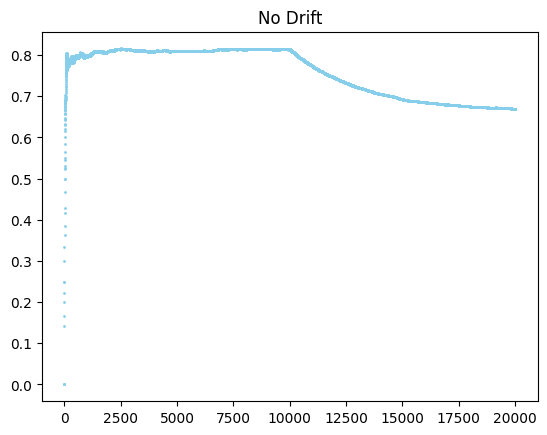

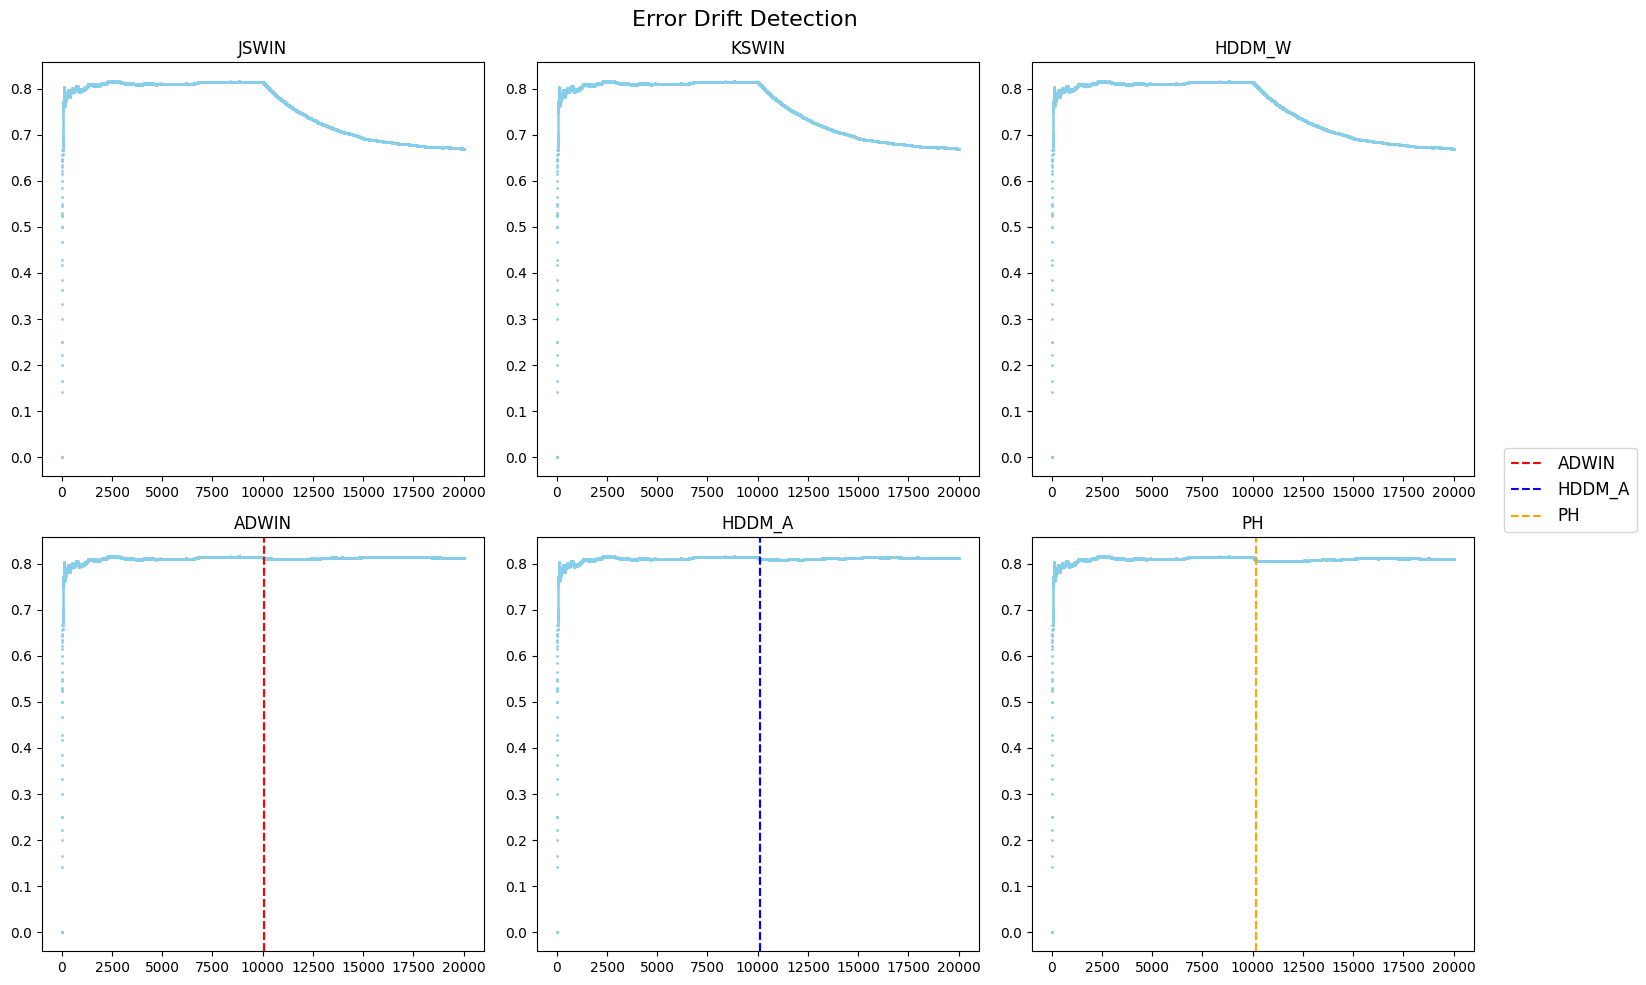

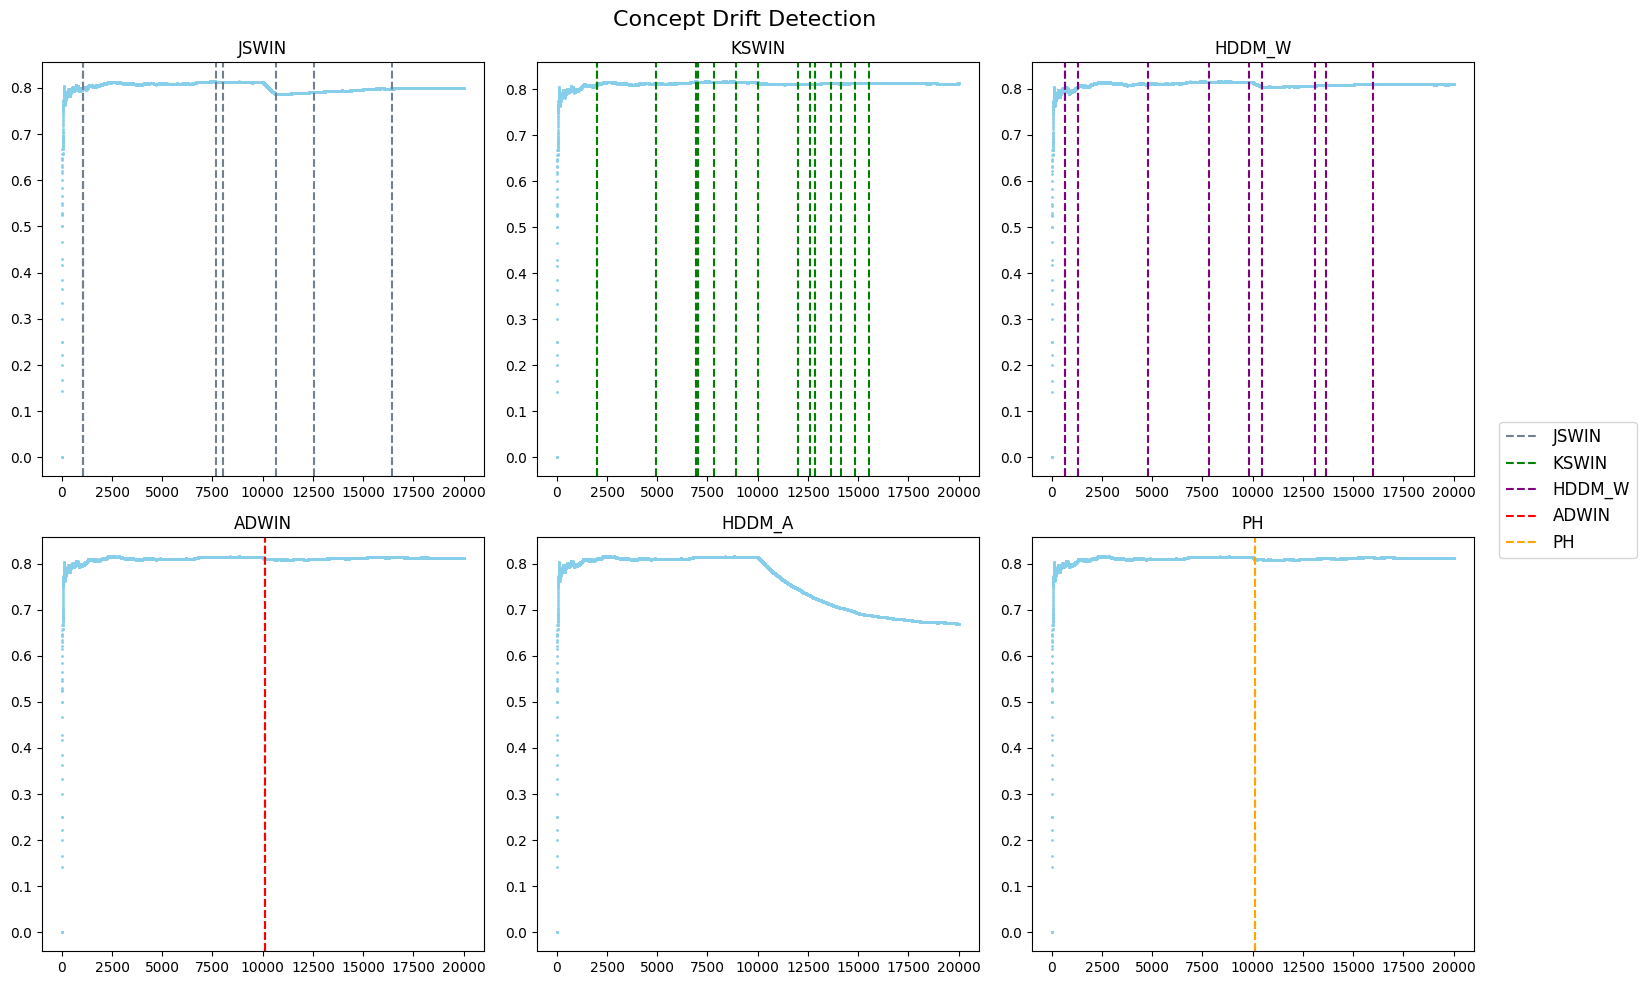

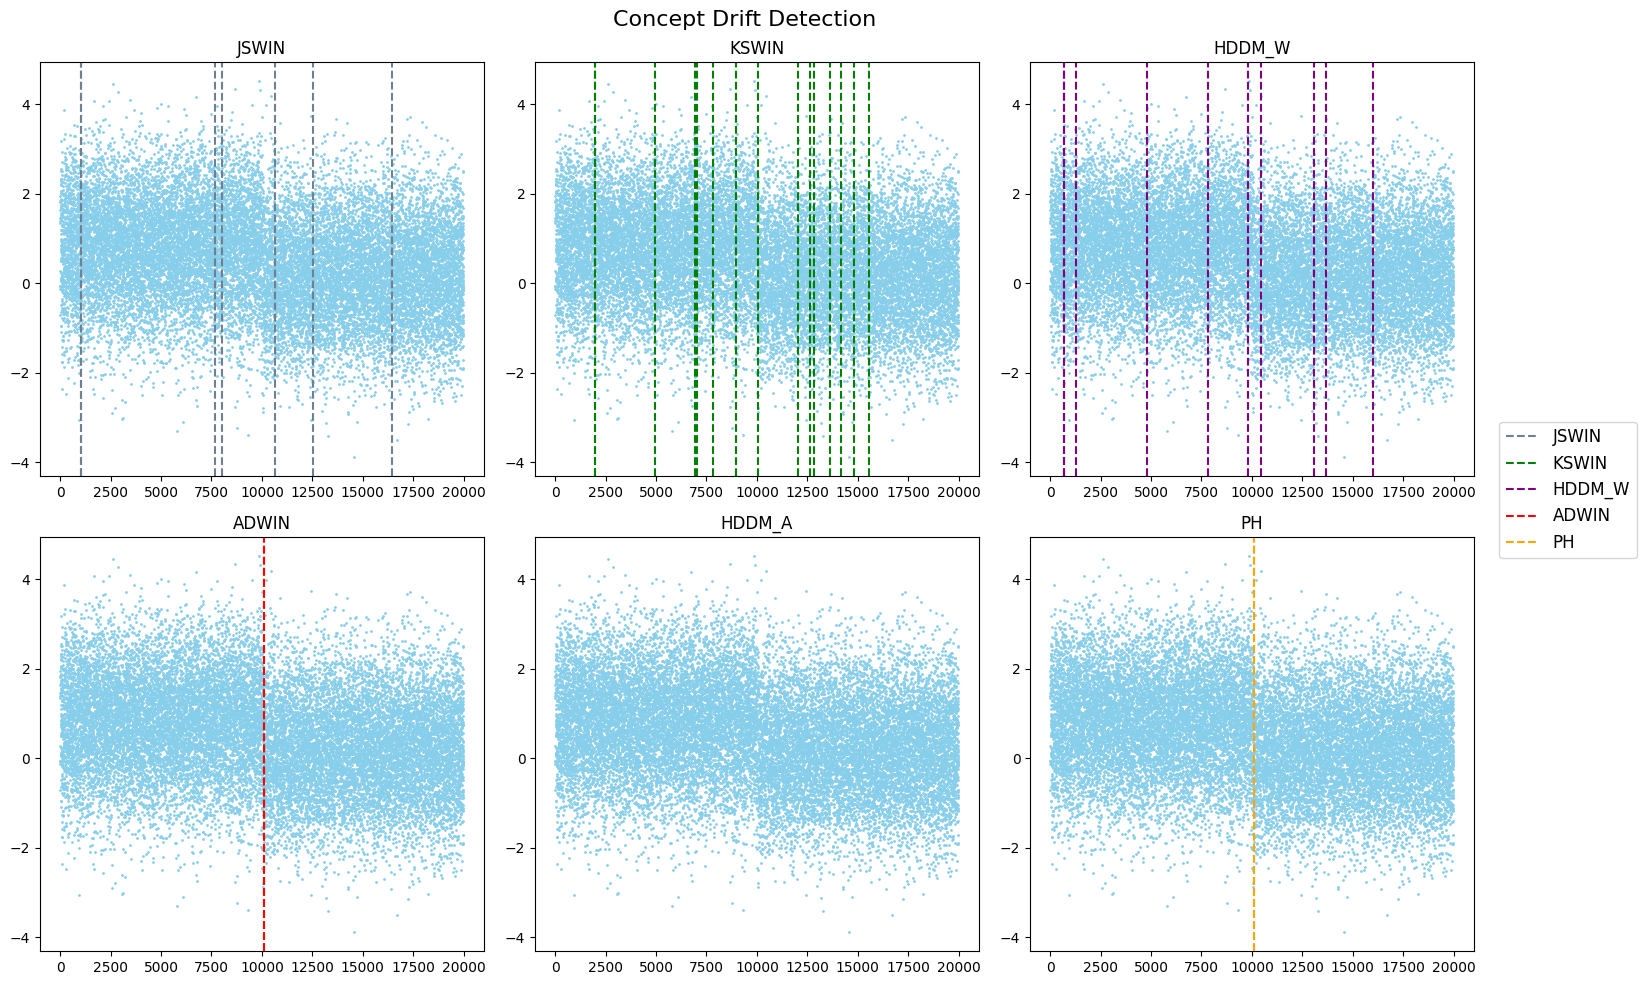

In [161]:
exp.plot(X)